# **Life-long Learning**

# **Introduction**
- The approaches of life-long learning can be categorized as three main categories according to this [dissertation](https://arxiv.org/pdf/1910.02718.pdf).
- In the research, the author investigated the models proposed from 2016 to 2019 and can be summarized as follows:
  - Replay-based methods
  - Regularization-based methods
  - Parameter isolation methods

<p align="center"><img width="70%" src="https://i.ibb.co/VDFJkWG/2019-12-29-17-25.png" /></p>

- In this tutorial, we will implement two *prior-focused* methods from *regularization-based methods*. That is, the ***EWC*** and ***MAS***. 

# **Import the Libraries**

In [ ]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import os
import random
from copy import deepcopy
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Build the Models**

- As we will focus on the life-long learning approaches, the model is a simple 6-layer fully-connected layer neuron network with relu as an activation function.

## Basic Model

In [ ]:
class Model(nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 10)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.relu(x)
    x = self.fc6(x)
    return x

## EWC (Elastic Weight Consolidation)

Imagine we have two tasks to be learned one by one with a model. In the EWC approach, the loss function is defined as follows.

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2$$

where
- $\mathcal{L}_B$ is loss on task B;
- $\mathcal{L}(\theta)$ is the common loss;
- $F_i$ is the guard on a specific parameter $\theta_{i}$;
- $\theta_{A,i}^{*}$ is the parameter after training on task A;
- $\theta_{i}$ is the current parameter of the model.

The model structure remains the same along with the training with task A and B.\
The equation to calculate $F_i$ is given as below.

$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*}) \nabla \log(p(y_n | x_n, \theta_{A}^{*})^T ] $$ 

From the equation, there are several things to be noticed:
- In $F$, only the diagonal value is used to approximate the $F_i$ value of each parameter.
- $p(y_n | x_n, \theta_{A}^{*})$ refers to the posterior probability of $y_n$ (label corresponding to $x_n$) given the data of previous task, $x_n$ and the model parameters $\theta_A^*$ saved from task A after training.
- Therefore, what we need to do is to compute the gradient of $p(y_n | x_n, \theta_{A}^{*})$. Then square it.

If you are interested in how the equation could be used to approximate the $F_i$, please refer to sections 2.4.1 and 2.4 [here](https://arxiv.org/pdf/1910.02718.pdf).

- Reference on EWC: [Overcoming catastrophic forgetting in neural networks](https://arxiv.org/pdf/1612.00796.pdf).

In [ ]:
class EWC(object):
  
  def __init__(self, model: nn.Module, dataloaders: list, device):
    self.model = model
    self.dataloaders = dataloaders
    self.device = device

    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} # get all the moel parameters
    self._means = {} # initialize the mean parameters
    self._precision_matrices = self._calculate_importance() # create the Fisher (F) matrix

    for n, p in self.params.items():
      self._means[n] = p.clone().detach() # compute the mean of each parameters based on previous task data

  
  def _calculate_importance(self):
    print('Computing EWC')
    precision_matrices = {}
    for n, p in self.params.items(): # initialize the Fisher Matrix with 0
      precision_matrices[n] = p.clone().detach().fill_(0)
    
    self.model.eval()
    dataloader_num = len(self.dataloaders)
    number_data = sum([len(loader) for loader in self.dataloaders])

    for dataloader in self.dataloaders:
      for data in dataloader:
        self.model.zero_grad()
        input = data[0].to(self.device)
        output = self.model(input).view(1, -1)
        label = output.max(1)[1].view(-1)

        # build the Fisher (F) Matrix
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()

        for n, p in self.model.named_parameters():
          precision_matrices[n].data += p.grad.data ** 2 / number_data
    
    precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices
  

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
      loss += _loss.sum()
    return loss

## MAS (Memory Aware Synapses)
Imagine we have two tasks to be learned one by one with a model. In the MAS approach, the loss function is defined as follows.

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

where $\Omega_i$ can be written as:
$$\Omega_i = || \frac{\partial \ell_2^2(M(x_k; \theta))}{\partial \theta_i} ||$$

where $x_k$ is the sample data from the previous task. What the equation does can be summarized as 3 steps below:
1. Compute the **L2 Norm** over the output vector of the last layer from the model ($M(x_k; \theta)$).
2. Calculate the gradient over each weight.
3. Get the absolute value from step 2.

For more information on MAS, please refer to the [paper](https://arxiv.org/pdf/1711.09601.pdf).

In [ ]:
class MAS(object):

  def __init__(self, model: nn.Module, dataloaders: list, device):
    self.model = model
    self.dataloaders = dataloaders
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} # get all the moel parameters
    self._means = {} # initialize the mean parameters
    self.device = device
    self._precision_matrices = self.calculate_importance() # create the Omega(Ω) Matrix

    for n, p in self.params.items():
      self._means[n] = p.clone().detach()
    
  def calculate_importance(self):
    print('Computing MAS')

    precision_matrices = {}
    for n, p in self.params.items(): # initialize the Omega(Ω) Matrix with 0
      precision_matrices[n] = p.clone().detach().fill_(0)
    
    self.model.eval()
    dataloader_num = len(self.dataloaders)
    num_data = sum([len(loader) for loader in self.dataloaders])
    for dataloader in self.dataloaders:
      for data in dataloader:
        self.model.zero_grad()
        output = self.model(data[0].to(self.device))

        # build the Omega(Ω) Matrix
        output.pow_(2)
        loss = torch.sum(output, dim=1)
        loss = loss.mean()
        loss.backward()

        for n, p in self.model.named_parameters():
          precision_matrices[n].data += p.grad.abs() / num_data # different from EWC
    precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices
  
  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
      loss += _loss.sum()
    return loss

# **Process the Data**

## Data Preprocessing

- Convert MNIST from [1 x 28 x 28] to [3 x 32 x 32].
- Convert USPS from [1 x 16 x 16] to [3 x 32 x 32].
- Normalize the images.

In [ ]:
class Convert2RGB(object):
  """
  Convert the image from 1 channel (gray) to 3 channels (RGB).
  """
  def __init__(self, num_channel):
    self.num_channel = num_channel
  
  def __call__(self, img):
    """
    Expand the image channel to the desired size (num_channel).
    """
    img_channel = img.size()[0]
    img = torch.cat([img] * (self.num_channel - img_channel + 1), 0)
    return img

class Pad(object):
  """
  Pad the height and width of the image to desired size.
  """
  def __init__(self, size, fill=0, padding_mode='constant'):
    self.size = size
    self.fill = fill
    self.padding_mode = padding_mode
  
  def __call__(self, img):
    img_size = img.size()[1]
    assert ((self.size - img_size) % 2 == 0)
    padding = (self.size - img_size) // 2
    padding = (padding, padding, padding, padding)
    return F.pad(img, padding, self.padding_mode, self.fill)
  
def get_transform():
  transform = transforms.Compose(
      [
       transforms.ToTensor(),
       Pad(32),
       Convert2RGB(3),
       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
      ]
  )
  return transform

## Prepare the Dataset

- MNIST: for a single image, the size is [28, 28, 1] (gray scale). 10 classes in total.
- SVHN: for a single image, the size is [32, 32, 3] (RGB). 10 classes in total.
- USPS: for a single image, the size is [16, 16, 1] (gray scale). 10 classes in total.

In [ ]:
class Data():

  def __init__(self, path):
    transform = get_transform()

    self.MNIST_dataset = datasets.MNIST(
        root=os.path.join(path, "MNIST"),
        transform=transform,
        train=True,
        download=True
    )

    self.SVHN_dataset = datasets.SVHN(
        root=os.path.join(path, "SVHN"),
        transform=transform,
        split='train',
        download=True
    )

    self.USPS_dataset = datasets.USPS(
        root=os.path.join(path, "USPS"),
        transform=transform,
        train=True,
        download=True
    )
  
  def get_datasets(self):
    a = [(self.SVHN_dataset, "SVHN"), (self.MNIST_dataset, "MNIST"), (self.USPS_dataset, "USPS")]
    return a

## Build the DataLoader

In [ ]:
class Dataloader():

  def __init__(self, dataset, batch_size, split_ratio=0.1):
    self.dataset = dataset[0]
    self.name = dataset[1]
    train_sampler, val_sampler = self.split_dataset(split_ratio)

    self.train_dataset_size = len(train_sampler)
    self.val_dataset_size = len(val_sampler)

    self.train_loader = data.DataLoader(self.dataset, batch_size=batch_size, sampler=train_sampler)
    self.val_loader = data.DataLoader(self.dataset, batch_size=batch_size, sampler=val_sampler)
    self.train_iter = self.infinite_iter()

  def split_dataset(self, split_ratio):
    data_size = len(self.dataset)
    split = int(data_size * split_ratio)
    indices = list(range(data_size))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = sampler.SubsetRandomSampler(train_idx)
    val_sampler = sampler.SubsetRandomSampler(valid_idx)
    return train_sampler, val_sampler

  def infinite_iter(self):
    it = iter(self.train_loader)
    while True:
      try:
        ret = next(it)
        yield ret
      except StopIteration:
        it = iter(self.train_loader)

# **utils**

## Store the Model

In [ ]:
def save_model(model, optimizer, store_model_path):
  # save the model and optimizer
  torch.save(model.state_dict(), f'{store_model_path}.ckpt')
  torch.save(optimizer.state_dict(), f'{store_model_path}.opt')
  return

## Load the Model

In [ ]:
def load_model(model, optimizer, load_model_path):
  # load the model and optimizer
  print(f'Load the model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  optimizer.load_state_dict(torch.load(f'{load_model_path}.opt'))
  return model, optimizer

## Build the Model and Optimizer

In [ ]:
def build_model(data_path, batch_size, learning_rate):
  # create the model
  model = Model().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  data = Data(data_path)
  datasets = data.get_datasets()
  tasks = []
  for dataset in datasets:
    tasks.append(Dataloader(dataset, batch_size))
    
  return model, optimizer, tasks

# **Define Training Functions**

## Normal Training (Baseline)

In [ ]:
def normal_train(model, optimizer, task, total_epochs, summary_epochs):
  model.train()
  model.zero_grad()
  criterion = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = criterion(outputs, labels)

    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()

    loss += ce_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print('\r', 'Train task {} [{}] loss: {:.3f}'.format(task.name, (total_epochs + epoch + 1), loss), end = ' ')
      losses.append(loss)
      loss = 0.0
  return model, optimizer, losses

## EWC Training

In [ ]:
def ewc_train(model, optimizer, task, total_epochs, summary_epochs, ewc, lambda_ewc):
  model.train()
  model.zero_grad()
  criterion = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = criterion(outputs, labels)
    total_loss = ce_loss
    ewc_loss = ewc.penalty(model)
    total_loss += lambda_ewc * ewc_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss += total_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print('\r', 'Train task {} [{}] loss: {:.3f}'.format(task.name, (total_epochs + epoch + 1), loss), end = ' ')
      losses.append(loss)
      loss = 0.0
  return model, optimizer, losses

## MAS Training

In [ ]:
def mas_train(model, optimizer, task, total_epochs, summary_epochs, mas_tasks, lambda_mas,alpha=0.8):
  model.train()
  model.zero_grad()
  ceriation = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = ceriation(outputs, labels)
    total_loss = ce_loss
    mas_tasks.reverse()
    if len(mas_tasks) > 1:
        preprevious = 1 - alpha
        scalars = [alpha,preprevious]
        for mas,scalar in zip(mas_tasks[:2],scalars):
            mas_loss = mas.penalty(model)
            total_loss += lambda_mas * mas_loss * scalar
    elif len(mas_tasks) == 1:
        mas_loss = mas_tasks[0].penalty(model)
        total_loss += lambda_mas * mas_loss
    else:
        pass
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss += total_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print('\r', 'Train task {} [{}] loss: {:.3f}'.format(task.name, (total_epochs + epoch + 1), loss), end = ' ')
      losses.append(loss)
      loss = 0.0
    
  return model, optimizer, losses

## Validation

In [ ]:
def val(model, task):
  model.eval()
  correct_cnt = 0
  for imgs, labels in task.val_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, pred_label = torch.max(outputs.data, 1)

    correct_cnt += (pred_label == labels.data).sum().item()
  return correct_cnt / task.val_dataset_size

## Main Training Process

In [ ]:
def train_process(model, optimizer, tasks, config):
  task_loss, acc = {}, {}
  for task_id, task in enumerate(tasks):
    print('\n')
    total_epochs = 0
    task_loss[task.name] = []
    acc[task.name] = []
    
    if config.mode == 'basic' or task_id == 0:
      while (total_epochs < config.num_epochs):
        model, optimizer, losses = normal_train(model, optimizer, task, total_epochs, config.summary_epochs)
        task_loss[task.name] += losses
      
        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))
        
        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)
    
    if config.mode == 'ewc' and task_id > 0:
      old_dataloaders = []
      for old_task in range(task_id): # use all the val data from previous tasks
        old_dataloaders += [tasks[old_task].val_loader]
      ewc = EWC(model, old_dataloaders, device)

      while (total_epochs < config.num_epochs):
        model, optimizer, losses = ewc_train(model, optimizer, task, total_epochs, config.summary_epochs, ewc, config.lifelong_coeff)
        task_loss[task.name] += losses

        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))
        
        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)

    if config.mode == 'mas' and task_id > 0:
      old_dataloaders = []
      mas_tasks = []
      for old_task in range(task_id): 
        old_dataloaders += [tasks[old_task].val_loader]
        mas = MAS(model, old_dataloaders, device)
        mas_tasks += [mas]
      while (total_epochs < config.num_epochs):
        model, optimizer, losses = mas_train(model, optimizer, task, total_epochs, config.summary_epochs, mas_tasks, config.lifelong_coeff)
        task_loss[task.name] +=  losses

        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))

        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)
  
  return task_loss, acc

# **Configurations**

In [ ]:
 class configurations(object):
  def __init__(self):
    self.batch_size = 256
    self.num_epochs = 10000
    self.store_epochs = 250
    self.summary_epochs = 250
    self.learning_rate = 0.0005
    self.load_model = False
    self.store_model_path = "./model"
    self.load_model_path = "./model"
    self.data_path = "./data"
    self.mode = None
    self.lifelong_coeff = 0.5

# **Main**

In [ ]:
"""
The training dataset order is svhn -> mnist -> usps.
"""
# import tqdm

if __name__ == '__main__':
  mode_list = ['mas', 'ewc', 'basic']

  ## hint: 謹慎的去選擇 lambda 超參數 / ewc: 80~400, mas: 0.1 - 10
  ############################################################################
  #####                           TODO 區塊 （ PART 1 ）                   #####
  ############################################################################ 
  coeff_list = [0.1, 80 ,0 ]  ## 你需要在這 微調 lambda 參數, mas, ewc, baseline=0##  
  ############################################################################
  #####                           TODO 區塊 （ PART 1 ）                   #####
  ############################################################################ 
  
  config = configurations()
  count = 0
  for mode in mode_list:
    config.mode = mode
    config.lifelong_coeff = coeff_list[count]
    print("{} training".format(config.mode))    
    model, optimizer, tasks = build_model(config.data_path, config.batch_size, config.learning_rate)
    print ("Finish build model")
    if config.load_model:
        model, optimizer = load_model(model, optimizer, config.load_model_path)
    task_loss, acc = train_process(model, optimizer, tasks, config)
    with open(f'./{config.mode}_acc.txt', 'w') as f:
        json.dump(acc, f)
    count += 1


mas training
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Finish build model


 Train task SVHN [10000] loss: 0.094 

Computing MAS
 Train task MNIST [10000] loss: 0.320 

Computing MAS
Computing MAS
 Train task USPS [10000] loss: 0.152 ewc training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 Train task SVHN [10000] loss: 0.089 

Computing EWC
 Train task MNIST [10000] loss: 0.074 

Computing EWC
 Train task USPS [10000] loss: 0.012 basic training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 Train task SVHN [10000] loss: 0.088 

 Train task MNIST [10000] loss: 0.008 

 Train task USPS [10000] loss: 0.001 

# **Plot the Images**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

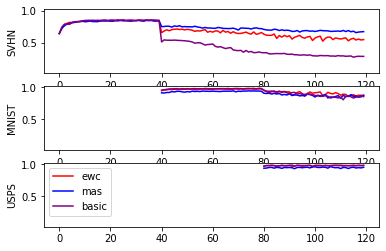

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_result(mode_list, task1, task2, task3):
  
  # draw the lines
  count = 0
  for reg_name in mode_list:
    label = reg_name
    with open(f'./{reg_name}_acc.txt', 'r') as f:
      acc = json.load(f)
    if count == 0: 
      color = 'red'
    elif count == 1:
      color= 'blue'
    else:
      color = 'purple'

    ax1 = plt.subplot(3, 1, 1)
    plt.plot(range(len(acc[task1])), acc[task1], color, label=label)
    ax1.set_ylabel(task1)
    ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
    plt.plot(range(len(acc[task3]), len(acc[task1])), acc[task2], color,label=label)
    ax2.set_ylabel(task2)
    ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
    ax3.set_ylabel(task3)
    plt.plot(range(len(acc[task2]), len(acc[task1])), acc[task3], color, label=label)
    count += 1
  plt.ylim((0.02,1.02))
  plt.legend()
  plt.show()
  return

mode_list = ['ewc', 'mas', 'basic']
plot_result(mode_list, 'SVHN', 'MNIST', 'USPS')